In [1]:
# Cài thư viện cần (dựa trên code trong repo)
!pip install transformers torch datasets accelerate

In [2]:
# Kiểm tra GPU có sẵn không
import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

# Cài lại các thư viện cần (nếu chưa chạy trước đó)
!pip install transformers torch datasets accelerate pandas scikit-learn tqdm

# Nếu bạn đã ở trong thư mục repo thì bỏ dòng này
%cd /content/Big-Five-personality-score-predictions_RoBERTa_and_BERT  # thay đổi nếu cần

GPU available: True
GPU name: Tesla P100-PCIE-16GB
[Errno 2] No such file or directory: '/content/Big-Five-personality-score-predictions_RoBERTa_and_BERT # thay đổi nếu cần'
/kaggle/working


In [3]:
# Đường dẫn đến file trong folder WevMining (thay tên file nếu khác)
file_path = "/kaggle/input/dataset/dataset (1).csv"  # hoặc .parquet nếu là Parquet

import pandas as pd

# Load file từ Drive
df = pd.read_csv(file_path)  # Nếu là Parquet: pd.read_parquet(file_path)

print("Cột gốc trong file:", df.columns.tolist())

# Rename cột để khớp với code/repo mong đợi (body cho text)
df = df.rename(columns={
    'text': 'body',
    'A': 'agr',
    'O': 'ope',
    'C': 'con',
    'E': 'ext',
    'N': 'neu'
})

df = df.sample(frac=0.1, random_state=42)

# Kiểm tra sau rename
print("\nCột sau khi rename:", df.columns.tolist())
print("\nSample 3 dòng đầu:")
print(df.head(3))


Cột gốc trong file: ['ope', 'con', 'ext', 'agr', 'neu', 'ptype', 'body', '__index_level_0__']

Cột sau khi rename: ['ope', 'con', 'ext', 'agr', 'neu', 'ptype', 'body', '__index_level_0__']

Sample 3 dòng đầu:
          ope   con   ext   agr   neu  ptype  \
258181    2.0  38.0  87.0  28.0   1.0      4   
768973   81.0  80.0  30.0  24.0  75.0     25   
1732080  29.0  40.0   6.0   7.0  98.0      1   

                                                      body  __index_level_0__  
258181   People who know they're close to zero balance ...            1386091  
768973                        Aww You are most welcome. =]            2044374  
1732080            Oh, didn't know it blocked her ult. TIL            1512060  


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim import AdamW
from tqdm import tqdm
import os

# Load dataset đã rename
df[['ext', 'neu', 'agr', 'con', 'ope']] = df[['ext', 'neu', 'agr', 'con', 'ope']]/100

print("Dataset ready. Shape:", df.shape)

# Hiển thị nội dung của roberta_large_pandora.py để so sánh
print("\n--- Nội dung của roberta_large_pandora.py ---")
!cat roberta_large_pandora.py
print("------------------------------------------")

2026-01-18 17:14:39.176197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768756479.335306      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768756479.382697      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768756479.778078      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768756479.778125      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768756479.778128      55 computation_placer.cc:177] computation placer alr

Dataset ready. Shape: (192420, 8)

--- Nội dung của roberta_large_pandora.py ---
cat: roberta_large_pandora.py: No such file or directory
------------------------------------------


In [5]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

max_length = 128  # Tăng lên 128 để capture tốt hơn (repo gốc 64 quá ngắn cho Reddit comment)

def tokenize_text(text):
    return tokenizer.encode_plus(
        str(text),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors=None
    )

df['body'] = df['body'].apply(tokenize_text)

print("Tokenization completed. Sample:", df['body'].iloc[0]['input_ids'][:10])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Tokenization completed. Sample: [0, 4763, 54, 216, 51, 214, 593, 7, 4276, 2394]


In [6]:
# Drop author nếu còn (dataset HF thường không có)
if 'author' in df.columns:
    df.drop(['author'], axis=1, inplace=True)

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

Train: 107755 | Val: 26939 | Test: 57726


In [7]:
class PersonalityDataset(Dataset):
    def __init__(self, tweets, targets):
        self.tweets = tweets
        self.targets = targets

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.tweets[idx]['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(self.tweets[idx]['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float)
        }

In [8]:
batch_size = 8  # Giảm nếu Colab T4 hết VRAM (8-16 OK cho roberta-large)

train_dataset = PersonalityDataset(df_train['body'].tolist(), df_train[['ext', 'neu', 'agr', 'con', 'ope']].values)
val_dataset = PersonalityDataset(df_val['body'].tolist(), df_val[['ext', 'neu', 'agr', 'con', 'ope']].values)
test_dataset = PersonalityDataset(df_test['body'].tolist(), df_test[['ext', 'neu', 'agr', 'con', 'ope']].values)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
class RoBERTaForPersonalityTraits(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-large')
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(1024, 5)  # 5 traits

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        output = self.dropout(pooled)
        return self.linear(output)

model = RoBERTaForPersonalityTraits()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.MSELoss()

print("Model loaded on:", device)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda


In [10]:
epochs = 10  # Bắt đầu với 3 để test, sau tăng
patience = 3
best_val_loss = float('inf')
patience_counter = 0
accumulation_steps = 4  # Gradient accumulation để tiết kiệm VRAM

log_file = 'roberta_large_results.txt'

with open(log_file, 'w') as f:
    f.write("Training started\n")

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        step = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/Training")
        for i, batch in enumerate(train_bar):
            if i % accumulation_steps == 0:
                optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, targets)

            loss = loss / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0 or i + 1 == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accumulation_steps
            step += 1

            train_bar.set_postfix({'loss': total_loss / step})

            # Checkpoint
            if step % 1000 == 0:
                torch.save(model.state_dict(), f'checkpoint_step_{step}.pth')

        avg_train_loss = total_loss / step
        f.write(f"Epoch {epoch+1}: Train Loss {avg_train_loss}\n")

        # Validation
        model.eval()
        val_loss = 0
        preds, trues = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['targets'].to(device)

                outputs = model(input_ids, attention_mask)
                val_loss += loss_fn(outputs, targets).item()

                preds.append(outputs.cpu().numpy())
                trues.append(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        f.write(f"Val Loss: {avg_val_loss}\n")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                f.write("Early stopping\n")
                break

    torch.save(model.state_dict(), 'final_model.pth')
    f.write("Training done\n")

Epoch 7/Training:  17%|█▋        | 2351/13470 [13:21<1:03:11,  2.93it/s, loss=0.0568]


KeyboardInterrupt: 

In [13]:
import os
from transformers import RobertaConfig, RobertaTokenizer

save_directory = "/content/drive/MyDrive/WebMining/MyFineTunedRoBERTa"  # Thư mục trên Drive
os.makedirs(save_directory, exist_ok=True)

# 1. Lưu state_dict (weights) - bạn đã có, nhưng lưu lại cho chắc
torch.save(model.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

# 2. Lưu config (tạo từ model gốc nếu chưa có custom config)
# Giả sử bạn dùng config từ 'roberta-large'
config = model.config if hasattr(model, 'config') else RobertaConfig.from_pretrained("roberta-large")
config.num_labels = 5  # Đảm bảo lưu số labels đúng
config.save_pretrained(save_directory)

# 3. Lưu tokenizer (từ lúc train)
tokenizer.save_pretrained(save_directory)

print(f"Model saved successfully to: {save_directory}")

Model saved successfully to: /content/drive/MyDrive/WebMining/MyFineTunedRoBERTa


In [11]:
model.eval()
test_loss = 0
all_preds = []
all_trues = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids, attention_mask)
        test_loss += loss_fn(outputs, targets).item()

        all_preds.append(outputs.cpu().numpy())
        all_trues.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_trues = np.concatenate(all_trues, axis=0)

trait_names = ["Ext", "Neu", "Agr", "Con", "Ope"]
for i in range(5):
    mse = mean_squared_error(all_trues[:, i], all_preds[:, i])
    print(f"{trait_names[i]} - MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f}")

Test: 100%|██████████| 7216/7216 [12:21<00:00,  9.73it/s]

Ext - MSE: 0.0944 | RMSE: 0.3072
Neu - MSE: 0.0963 | RMSE: 0.3103
Agr - MSE: 0.0901 | RMSE: 0.3002
Con - MSE: 0.0686 | RMSE: 0.2619
Ope - MSE: 0.0943 | RMSE: 0.3070


In [14]:
# Load best model (đã lưu)
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))  # Hoặc đường dẫn Drive nếu mount
model.to(device)
model.eval()

# Chạy evaluation trên val_loader hoặc test_loader
val_loss = 0
preds, trues = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Evaluation on Val"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        outputs = model(input_ids, attention_mask)
        val_loss += loss_fn(outputs, targets).item()
        preds.append(outputs.cpu().numpy())
        trues.append(targets.cpu().numpy())

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

avg_val_loss = val_loss / len(val_loader)
rmse = np.sqrt(mean_squared_error(trues, preds))  # Overall RMSE
r2 = r2_score(trues, preds)  # Overall R²

print(f"Final Val Loss: {avg_val_loss:.4f}")
print(f"Overall RMSE: {rmse:.4f}")
print(f"Overall R²: {r2:.4f}")

# Per trait RMSE (như bạn đã có)
trait_names = ["Ext", "Neu", "Agr", "Con", "Ope"]
for i in range(5):
    trait_rmse = np.sqrt(mean_squared_error(trues[:, i], preds[:, i]))
    trait_r2 = r2_score(trues[:, i], preds[:, i])
    print(f"{trait_names[i]} - RMSE: {trait_rmse:.4f} | R²: {trait_r2:.4f}")

Final Evaluation on Val: 100%|██████████| 3368/3368 [05:46<00:00,  9.73it/s]

Final Val Loss: 0.0801
Overall RMSE: 0.2830
Overall R²: 0.0971
Ext - RMSE: 0.2849 | R²: 0.0796
Neu - RMSE: 0.2916 | R²: 0.1136
Agr - RMSE: 0.2807 | R²: 0.1318
Con - RMSE: 0.2539 | R²: 0.0908
Ope - RMSE: 0.3015 | R²: 0.0697


In [18]:
with open('roberta_large_results.txt', 'a') as f:
    f.write(f"\nFinal Evaluation:\nVal Loss: {avg_val_loss:.4f}\nOverall RMSE: {rmse:.4f}\nOverall R²: {r2:.4f}\n")

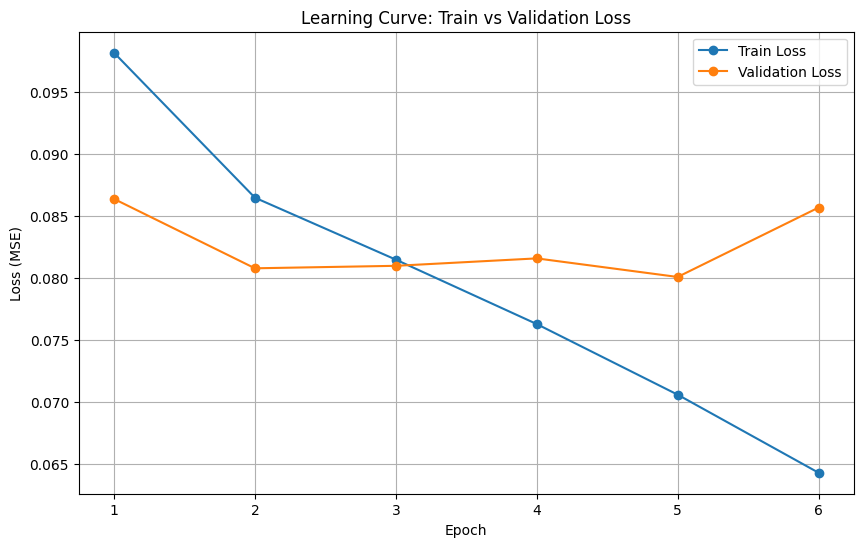

In [19]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6]
train_loss = [0.0982, 0.0865, 0.0815, 0.0763, 0.0706, 0.0643]
val_loss = [0.0864, 0.0808, 0.0810, 0.0816, 0.0801, 0.0857]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning Curve: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('learning_curve.png')
plt.show()

In [ ]:
# Cell: Train và Eval Baseline SVM + TF-IDF (sử dụng df_train, df_test đã có sẵn)
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR  # SVR cho regression (multi-output)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Chuẩn bị data từ df_train và df_test (text và labels)
traits = ['ext', 'neu', 'agr', 'con', 'ope']  # Các trait Big Five

X_train = df_train['body'].astype(str)  # Text train
y_train = df_train[traits].values       # Labels train (shape: n_samples x 5)

X_test = df_test['body'].astype(str)    # Text test
y_test = df_test[traits].values         # Labels test

# Pipeline đơn giản: TF-IDF + SVR (rbf kernel, default params)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')),  # TF-IDF features
    ('svr', MultiOutputRegressor(SVR(kernel='rbf', C=1.0, epsilon=0.1)))  # SVR cho từng trait
])

# Train baseline
print("Training SVM + TF-IDF baseline...")
pipeline.fit(X_train, y_train)

# Predict trên test set
preds = pipeline.predict(X_test)

# Tính metrics
overall_rmse = np.sqrt(mean_squared_error(y_test, preds))
overall_r2 = r2_score(y_test, preds, multioutput='uniform_average')  # Overall R²

print(f"Baseline SVM+TF-IDF - Overall RMSE: {overall_rmse:.4f}")
print(f"Baseline SVM+TF-IDF - Overall R²: {overall_r2:.4f}")

# Per-trait RMSE và R²
trait_names = ["Ext", "Neu", "Agr", "Con", "Ope"]
for i, name in enumerate(trait_names):
    trait_rmse = np.sqrt(mean_squared_error(y_test[:, i], preds[:, i]))
    trait_r2 = r2_score(y_test[:, i], preds[:, i])
    print(f"{name} - RMSE: {trait_rmse:.4f} | R²: {trait_r2:.4f}")